In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import nilearn as nl
import nibabel as nib
import cv2
from IPython.display import clear_output

In [2]:
test_img = nib.load(r'../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()

In [3]:
test_img.shape

(240, 240, 155)

## IS-Gen Without Autoencoder Part 1

In [4]:
IMAGE_SIZE = 256

In [5]:
'''Non-Convolution Part 1
in1 = tf.keras.layers.Input(shape=(256, 256, 1), name='ina')
z = tf.keras.layers.Flatten()(in1)
z = tf.keras.layers.Dense(512, activation='relu')(z)

in2 = tf.keras.layers.Input(shape=(256, 256, 1), name='inb')
x = tf.keras.layers.Flatten()(in2)
x = tf.keras.layers.Dense(512, activation='relu')(x)

concat = tf.keras.layers.Concatenate(axis=-1, name='cat')([z, x])
y = tf.keras.layers.Dense(65536, activation='relu')(concat)
out = tf.keras.layers.Reshape((256, 256, 1))(y)

part1 = tf.keras.models.Model(inputs=[in1, in2], outputs=[out])
part1.summary()
'''

"Non-Convolution Part 1\nin1 = tf.keras.layers.Input(shape=(256, 256, 1), name='ina')\nz = tf.keras.layers.Flatten()(in1)\nz = tf.keras.layers.Dense(512, activation='relu')(z)\n\nin2 = tf.keras.layers.Input(shape=(256, 256, 1), name='inb')\nx = tf.keras.layers.Flatten()(in2)\nx = tf.keras.layers.Dense(512, activation='relu')(x)\n\nconcat = tf.keras.layers.Concatenate(axis=-1, name='cat')([z, x])\ny = tf.keras.layers.Dense(65536, activation='relu')(concat)\nout = tf.keras.layers.Reshape((256, 256, 1))(y)\n\npart1 = tf.keras.models.Model(inputs=[in1, in2], outputs=[out])\npart1.summary()\n"

In [6]:
in1 = tf.keras.layers.Input(shape=(256, 256, 1), name='ina')
z = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(in1)
z = tf.keras.layers.MaxPool2D(2)(z)
z = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(z)
z = tf.keras.layers.MaxPool2D(2)(z)
z = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(z)
z = tf.keras.layers.MaxPool2D(2)(z)
z = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(z)
z = tf.keras.layers.MaxPool2D(2)(z)

in2 = tf.keras.layers.Input(shape=(256, 256, 1), name='inb')
x = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(in2)
x = tf.keras.layers.MaxPool2D(2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D(2)(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D(2)(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = tf.keras.layers.MaxPool2D(2)(x)

concat = tf.keras.layers.Concatenate(axis=-1, name='cat')([z, x])

y = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(concat)
y = tf.keras.layers.UpSampling2D(2)(y)
y = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(y)
y = tf.keras.layers.UpSampling2D(2)(y)
y = tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same')(y)
y = tf.keras.layers.UpSampling2D(2)(y)
y = tf.keras.layers.Conv2DTranspose(16, 3, activation='relu', padding='same')(y)
y = tf.keras.layers.UpSampling2D(2, name='u2u')(y)
out = tf.keras.layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(y)

part1 = tf.keras.models.Model(inputs=[in1, in2], outputs=[out])

part1.summary()

2022-01-20 21:49:15.123179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
ina (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
inb (InputLayer)                [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         ina[0][0]                        
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 16) 160         inb[0][0]                        
______________________________________________________________________________________________

2022-01-20 21:49:15.234979: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 21:49:15.235712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-20 21:49:15.236787: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-20 21:49:15.247165: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [7]:
part2 = tf.keras.models.Sequential([tf.keras.layers.Input((IMAGE_SIZE, IMAGE_SIZE, 1)),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.MaxPool2D(2),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.MaxPool2D(2),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])
part2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 230400)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [8]:
# part1_weights = '../input/mrequalizer-weights/part1_updated.h5'
# part2_weights = '../input/mrequalizer-weights/part2_updated.h5'

# part1 = tf.keras.models.load_model(part1_weights)
# part2 = tf.keras.models.load_model(part2_weights)

**Loading in Data**

In [9]:
import random
def generator(filenames):
    
    def callable_generator():
        for filename in filenames:
            loaded = nib.load(filename).get_fdata()
            indeces = list(range(loaded.shape[-1]-4))
            max_pix_val = np.max(loaded)
            min_pix_val = np.min(loaded)
            random.shuffle(indeces)
            for i in indeces:
                n = random.randint(2, 4)
                while i+(2*n) >= loaded.shape[-1]:
                    n = random.randint(2, 4)
                in1 = loaded[:, :, i]
                y = loaded[:, :, i+n]
                in2 = loaded[:, :, i+(2*n)]
                if np.sum(in1) == 0 and np.sum(in2) == 0:
                    continue
                resized1 = cv2.resize(in1, (IMAGE_SIZE, IMAGE_SIZE))/max_pix_val
                resized2 = cv2.resize(in2, (IMAGE_SIZE, IMAGE_SIZE))/max_pix_val
                y_resized = cv2.resize(y, (IMAGE_SIZE, IMAGE_SIZE))/max_pix_val
                arr = np.empty((2, IMAGE_SIZE, IMAGE_SIZE, 1))
                arr[0] = resized1.reshape(IMAGE_SIZE, IMAGE_SIZE, 1)
                arr[1] = resized2.reshape(IMAGE_SIZE, IMAGE_SIZE, 1)
#                 yield {'ina': resized1.reshape(258, 258, 1), 'inb': resized2.reshape(258, 258, 1)}, y_resized.reshape(258, 258, 1)            
                yield arr, y_resized.reshape(IMAGE_SIZE, IMAGE_SIZE, 1)            

    return callable_generator

In [10]:
TRAIN_DIR = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
VAL_DIR = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'
fileset1 = []
fileset2 = []
for path in os.listdir(TRAIN_DIR):
    full_path = os.path.join(TRAIN_DIR, path)
    if os.path.isdir(full_path):
        for file in os.listdir(full_path):
            if 'seg' not in file and 't1.nii' not in file:
#                 print('hi', end=' ')
                fileset1.append(os.path.join(full_path, file))
            
for path in os.listdir(VAL_DIR):
    full_path = os.path.join(VAL_DIR, path)
    if os.path.isdir(full_path):
        for file in os.listdir(full_path):
            if 'seg' not in file and 't1.nii' not in file:
                fileset2.append(os.path.join(full_path, file))

In [11]:
all_files = fileset1+fileset2

In [12]:
t1ce = [file for file in all_files if 't1ce' in file]
t2 = [file for file in all_files if 't2' in file]
flair = [file for file in all_files if 'flair' in file]

In [13]:
from sklearn.model_selection import train_test_split

flair_train, flair_val = train_test_split(flair, test_size=0.2, random_state=42)
t1ce_train, t1ce_val = train_test_split(t1ce, test_size=0.2, random_state=42)
t2_train, t2_val = train_test_split(t2, test_size=0.2, random_state=42)

In [14]:
flair_train_dataset = tf.data.Dataset.from_generator(generator(flair_train),
                                              (tf.float32, tf.float32),
                                              ((2, IMAGE_SIZE, IMAGE_SIZE, 1), (IMAGE_SIZE, IMAGE_SIZE, 1)))
t1ce_train_dataset = tf.data.Dataset.from_generator(generator(t1ce_train),
                                              (tf.float32, tf.float32),
                                              ((2, IMAGE_SIZE, IMAGE_SIZE, 1), (IMAGE_SIZE, IMAGE_SIZE, 1)))
t2_train_dataset = tf.data.Dataset.from_generator(generator(t2_train),
                                              (tf.float32, tf.float32),
                                              ((2, IMAGE_SIZE, IMAGE_SIZE, 1), (IMAGE_SIZE, IMAGE_SIZE, 1)))


In [15]:
BATCH_SIZE = 1
def prep_data(train_dataset):
    train_dataset = train_dataset.cache().batch(BATCH_SIZE).repeat()
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return train_dataset
flair_train_dataset = prep_data(flair_train_dataset)
t1ce_train_dataset = prep_data(t1ce_train_dataset)
t2_train_dataset = prep_data(t2_train_dataset)

In [16]:
def show_test_case(test_case, mid_slice_ind=21):
    test_img = nib.load(test_case).get_fdata()
    max_pix = np.max(test_img)
    in1 = cv2.resize(test_img[:, :, mid_slice_ind-4], (IMAGE_SIZE, IMAGE_SIZE))/max_pix
    in2 = cv2.resize(test_img[:, :, mid_slice_ind+4], (IMAGE_SIZE, IMAGE_SIZE))/max_pix
    label = cv2.resize(test_img[:, :, mid_slice_ind], (IMAGE_SIZE, IMAGE_SIZE))/max_pix
    in1 = in1.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1)
    in2 = in2.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1)
    data = [in1, in2]
    output = part1(data)
    f, axarr = plt.subplots(1, 2, squeeze=False)
    axarr[0][0].axis(False)
    axarr[0][1].axis(False)
    axarr[0][0].imshow(label, cmap='gray', vmin=0., vmax=1.)
    axarr[0][1].imshow(output[0, :, :, 0], cmap='gray', vmin=0., vmax=1.)
    return label, output[0, :, :, 0]

In [17]:
def part1_loss(y_true, y_pred, disc_pred, mse_weight=1e-3, ce_weight=1.):
#     mse_loss = tf.keras.losses.MeanSquaredError()
#     mse = mse_loss(y_true, y_pred)
    # Weighted MSE
    black = tf.reduce_mean(((y_true[y_true == 0.] - y_pred[y_true == 0.])**2))
    non_black = tf.reduce_mean(((y_true[y_true != 0.] - y_pred[y_true != 0.])**2))*5
    mse = black+non_black
#     if mse.numpy() >= 1.:
#         print('ERROR')
# #         print(type(y_true.numpy()))
#         np.save('error_pred.npy', y_pred.numpy())
#         np.save('error_true.npy', y_true.numpy())
# #         error_pred = y_pred
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    ce = cross_entropy(tf.ones_like(disc_pred), disc_pred)
    return tf.reduce_mean((mse*mse_weight)+(ce*ce_weight))

def discriminator_loss(real_output, fake_output):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return tf.reduce_mean(total_loss)

In [18]:
LEARNING_RATE = 1e-4
generator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
discriminator_optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
MSE_WEIGHT = 1.
CE_WEIGHT = 0.03
tf.config.run_functions_eagerly(True)
@tf.function
def train_step(batch, adversarial=True):
    part2.trainable = adversarial
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        y1 = tf.constant([[0.]] * BATCH_SIZE + [[1.]] * BATCH_SIZE)
        in1 = batch[0][:, 0, ...]
        in2 = batch[0][:, 1, ...]
        data = [in1, in2]
        gen_images = part1(data, training=True)
        fake_output = part2(gen_images, training=adversarial)
        real_output = part2(in1, training=adversarial)
        p1_loss = part1_loss(batch[1], gen_images, fake_output, 
                             mse_weight=MSE_WEIGHT, ce_weight= (CE_WEIGHT if adversarial else 0.))
#         if adversarial:
        p2_loss = discriminator_loss(real_output, fake_output)
    
    gradients_of_generator = gen_tape.gradient(p1_loss, part1.trainable_variables)
#     if adversarial:
    gradients_of_discriminator = disc_tape.gradient(p2_loss, part2.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, part2.trainable_variables))
        
    generator_optimizer.apply_gradients(zip(gradients_of_generator, part1.trainable_variables))
    if adversarial:
        return p1_loss, p2_loss
    return p1_loss, p1_loss

        
def train_gan(train_dataset, n_epochs=50, max_steps_per_epoch=None, adversarial=False):
    for epoch in range(n_epochs):
        for i, batch in enumerate(train_dataset):
            if max_steps_per_epoch is not None:
                if i == max_steps_per_epoch:
                    break
#             adversarial = (epoch >= 1)
            l1, l2 = train_step(batch, adversarial=adversarial)
            del batch
            clear_output(wait=True)
            print("Epoch {}/{}".format(epoch + 1, n_epochs))
            print(f'Step {i+1}')
            print(f'Generator Loss: {round(l1.numpy(), 2)}')
            if adversarial:
                print(f'Discriminator Loss: {round(l2.numpy(), 2)}')
#             show_test_case(r'../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/BraTS20_Training_001/BraTS20_Training_001_flair.nii')

In [19]:
for i in range(20):
    train_gan(t2_train_dataset, n_epochs=5, max_steps_per_epoch=1000, adversarial=(i%2 != 0))
#     train_gan(5, max_steps_per_epoch=1000, adversarial=)

Epoch 5/5
Step 1000
Generator Loss: 0.5199999809265137
Discriminator Loss: 3.4800000190734863


2022-01-21 00:06:46.130306: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [20]:
# part1.save('t2_part1.h5')
# part2.save('t2_part2.h5')

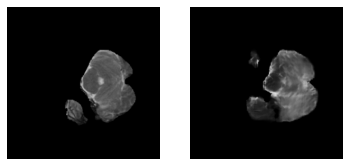

In [21]:
label, output = show_test_case(t2_val[2],
                       mid_slice_ind=27)

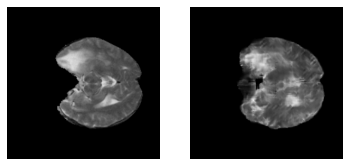

In [22]:
label, output = show_test_case(t2_val[2],
                       mid_slice_ind=50)

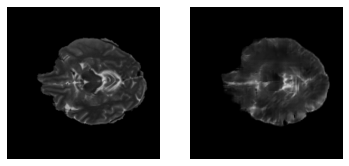

In [23]:
label, output = show_test_case(t2_val[3],
                       mid_slice_ind=50)

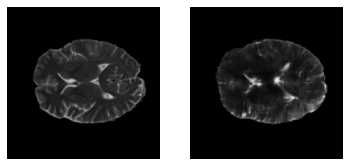

In [24]:
label, output = show_test_case(t2_val[3],
                       mid_slice_ind=68)

In [25]:
# def get_mse()

Part 2 Sequential Model (OLD):
```python
part2 = tf.keras.models.Sequential([tf.keras.layers.Input((258, 258, 1)),
                                    tf.keras.layers.Conv2D(32, 3, activation='relu'),
                                    tf.keras.layers.MaxPool2D(2),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.MaxPool2D(2),
                                    tf.keras.layers.Conv2D(64, 3, activation='relu'),
                                    tf.keras.layers.Flatten(),
                                    tf.keras.layers.Dense(128, activation='relu'),
                                    tf.keras.layers.Dense(1, activation='sigmoid')])
part2.summary()
```